# Decision Trees

In [154]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import cross_validation
from sklearn import tree as Tree
from sklearn import ensemble
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus
import sklearn.tree
%matplotlib inline 

## Load in data

In [240]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/master_8020_df.csv',index_col=0)

In [241]:
data.head(5)

,Previous_10_Left_Choice,Previous_10_Right_Choice,Previous_10_Left_Reward,Previous_10_Right_Reward,Streak,5_Port,5_Reward,5_ITI,5_trialDuration,4_Port,...,2_Reward,2_ITI,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,0_trialDuration,Decision
0,10.0,0.0,8.0,0.0,-1.0,1.0,0.0,3.286,0.407,1.0,...,1.0,2.234,0.325,1.0,0.0,2.133,0.482,1.411,0.435,1.0
1,10.0,0.0,7.0,0.0,-2.0,1.0,1.0,2.405,0.463,1.0,...,0.0,2.133,0.482,1.0,0.0,1.411,0.435,2.169,0.395,0.0
2,9.0,1.0,6.0,0.0,-3.0,1.0,1.0,2.379,0.367,1.0,...,0.0,1.411,0.435,0.0,0.0,2.169,0.395,3.838,0.469,0.0
3,8.0,2.0,5.0,0.0,-4.0,1.0,1.0,2.234,0.325,1.0,...,0.0,2.169,0.395,0.0,0.0,3.838,0.469,1.846,0.378,1.0
4,8.0,2.0,5.0,0.0,1.0,1.0,0.0,2.133,0.482,1.0,...,0.0,3.838,0.469,1.0,1.0,1.846,0.378,1.527,0.416,1.0


In [242]:
data = data.drop('0_trialDuration',axis=1)
data.head(2)

,Previous_10_Left_Choice,Previous_10_Right_Choice,Previous_10_Left_Reward,Previous_10_Right_Reward,Streak,5_Port,5_Reward,5_ITI,5_trialDuration,4_Port,...,2_Port,2_Reward,2_ITI,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision
0,10.0,0.0,8.0,0.0,-1.0,1.0,0.0,3.286,0.407,1.0,...,1.0,1.0,2.234,0.325,1.0,0.0,2.133,0.482,1.411,1.0
1,10.0,0.0,7.0,0.0,-2.0,1.0,1.0,2.405,0.463,1.0,...,1.0,0.0,2.133,0.482,1.0,0.0,1.411,0.435,2.169,0.0


In [243]:
#extract features and decisions
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

# Change 'y' so that 1 corresponds to a switch, and 0 corresponds to no switch

In [244]:
y_diff = np.diff(y)
x = x[1:,:]
y = np.abs(y_diff)

print(x.shape)
print(y_diff.shape)

(11325, 26)
(11325,)


## Use only outcome features

In [245]:
data = data.iloc[1:,:]
data['Decision'] = y

outcome_features = ['Streak','5_Reward','4_Reward','3_Reward','2_Reward','1_Reward','Decision']

data_outcome = data[outcome_features]

x = data_outcome.iloc[:,:-1].values
y = data_outcome.iloc[:,-1].values

#uncomment if you want to run on all features
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [246]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [247]:
print('# train trials: %.0f | # switches: %.0f --> %.01f percent' % (y_train.shape[0],np.sum(y_train),np.sum(y_train)*100.0/y_train.shape[0]))
print('# test trials: %.0f | # switches: %.0f --> %.01f percent' % (y_test.shape[0],np.sum(y_test),np.sum(y_test)*100.0/y_test.shape[0]))

# train trials: 7927 | # switches: 638 --> 8.0 percent
# test trials: 3398 | # switches: 259 --> 7.6 percent


# Decision Tree with all outcome features

In [253]:
tree = Tree.DecisionTreeClassifier(max_depth = 3,class_weight='balanced',random_state=1)
tree.fit(x_train,y_train)
y_predict = tree.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         2358.0          781.0
True YES          22.0          237.0

F1: 0.371

Accuracy on class 0: 0.75
Accuracy on class 1: 0.92



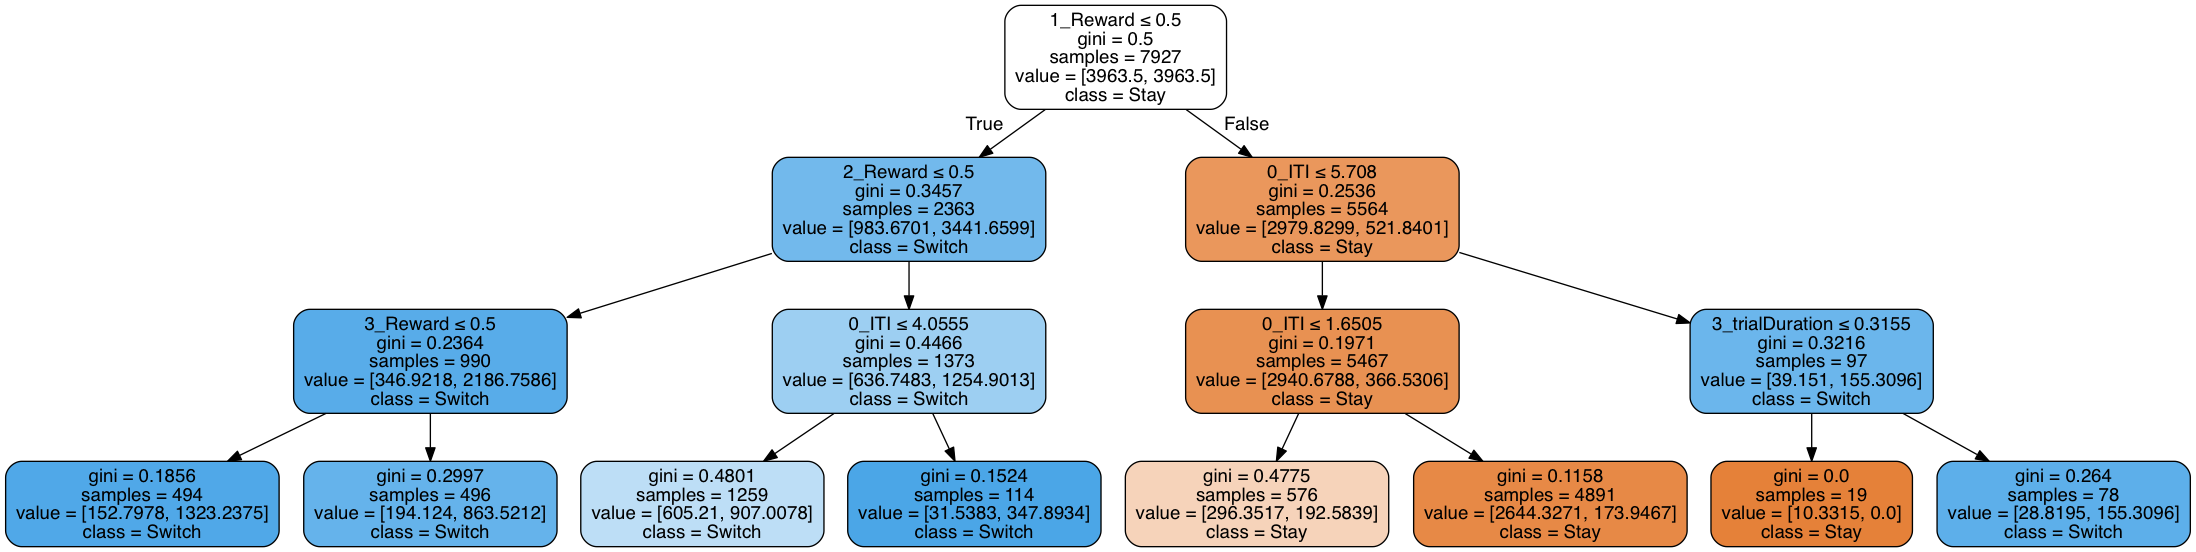

In [254]:
dot_data = Tree.export_graphviz(tree,out_file=None,
                     feature_names=data.columns.values[:-1],
                     class_names = ['Stay','Switch'],
                     filled=True,rounded=True,special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

This isn't sensitive to max_depth i.e. it does not improve for any number > 1. 

In [215]:
tree.feature_importances_

array([  1.16124430e-02,   9.40540579e-04,   6.56420046e-03,
         1.15622366e-02,   4.42385218e-02,   0.00000000e+00,
         5.11455709e-04,   3.58800024e-02,   2.23780753e-02,
         0.00000000e+00,   6.40295215e-03,   4.34065033e-02,
         4.76124950e-02,   3.97224934e-04,   4.18890988e-03,
         5.22674057e-02,   3.30093145e-02,   0.00000000e+00,
         0.00000000e+00,   4.56217241e-02,   1.40776989e-02,
         0.00000000e+00,   4.05320381e-01,   4.60246050e-02,
         4.05144654e-02,   1.27468844e-01])

# Try boosting single feature decision trees

In [239]:
# boosting: many many weak classifiers (max_depth=1) refine themselves sequentially
# tree is the default the base classifier
estimator = ensemble.GradientBoostingClassifier(n_estimators=4, learning_rate=1, max_depth=10, random_state=0)
estimator.fit(x_train, y_train)
y_pred = estimator.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_pred,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         2310.0           51.0
True YES          32.0          129.0

F1: 0.757

Accuracy on class 0: 0.98
Accuracy on class 1: 0.80



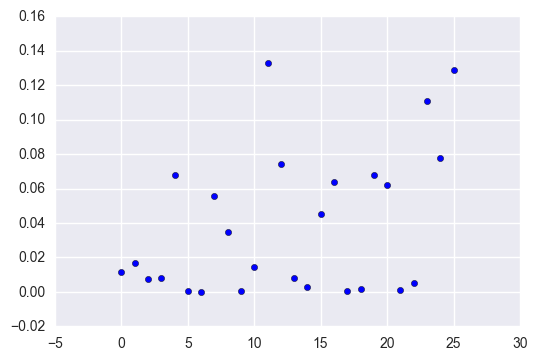

In [97]:
plt.scatter(np.arange(estimator.feature_importances_.shape[0]),estimator.feature_importances_)

# Benchmark model --> what if we just predict the mouse switches every time it doesn't get a reward?

In [190]:
data_outcome.columns.get_loc('2_Reward')

4

In [191]:
y_predict = (x_test[:,4] == 0).astype('int')
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         1749.0          520.0
True YES          64.0          189.0

F1: 0.393

Accuracy on class 0: 0.77
Accuracy on class 1: 0.75



In [17]:
print('# of testing switches')
np.sum(y_test)

# of testing switches


180.0

In [18]:
print('# of testing trials with 1_Reward == 1')
np.sum(x_test[:,22])

# of testing trials with 1_Reward == 1


1773.0

In [19]:
print('# of test trials with 1_Reward == 0')
np.sum(x_test[:,22] == 0)

# of test trials with 1_Reward == 0


749

In [20]:
print('# of test switches when 1_Reward == 0')
np.sum(y_test[x_test[:,22] == 0])

# of test switches when 1_Reward == 0


159.0